# SPINNA sample notebook
This notebook illustrates how to use SPINNA's API, focusing on the exemplary EGFR data which can be found in the "data" folder.

In [1]:
from picasso import io, spinna
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# USER PARAMETERS
PIXELSIZE = 130 # camera pixel size, nm - note that Picasso expresses coordinates in camera pixels, not nm
LABEL_UNC = 6.0 # label position uncertainty, nm
LE = 0.375 # labeling efficiency, 37.5%
ROI = 10_000 # simulated region of interest, nm
GRANULARITY = 34
N_SIM = 30 # number of simulations for each SPINNA fitting round 

In [4]:
# load experimental data
path_egfr = "egfr_mols.hdf5" # change if needed
egfr_mols, info = io.load_locs(path_egfr) # open the molecules with metadata
egfr_coords = np.stack([egfr_mols["x"], egfr_mols["y"]], axis=1) * PIXELSIZE # xy coordinates in nm
n_egfr = int(egfr_coords.shape[0] / LE) # number of EGFR molecules to be simulated

In [5]:
# define structures: monomer, dimer, tetramer
monomer = spinna.Structure(title="Monomer")
monomer.define_coordinates(target="EGFR", x=[0], y=[0], z=[0])
dimer = spinna.Structure(title="Dimer")
dimer.define_coordinates(target="EGFR", x=[-10.5, 10.5], y=[0, 0], z=[0, 0])
tetramer = spinna.Structure(title="Tetramer")
tetramer.define_coordinates(target="EGFR", x=[-31.5, -10.5, 10.5, 31.5], y=[0, 0, 0, 0], z=[0, 0, 0, 0])
structures = [monomer, dimer, tetramer]

In [6]:
print(dimer)

Type: Structure, Title: Dimer
Coordinates below: x, y, z (nm)

EGFR:
-10.5, 0, 0
10.5, 0, 0



In [7]:
# set up the mixer object which is used for simulating the structures
mixer = spinna.StructureMixer(
    structures=structures,
    label_unc={"EGFR": LABEL_UNC},
    le={"EGFR": LE},
    width=ROI, height=ROI,
)

In [8]:
# generate parameter search space - tested stoichiometries
search_space = spinna.generate_N_structures(
    structures=structures,
    N_total={"EGFR": n_egfr},
    granularity=GRANULARITY,
)
# search space contains the numbers of structures to simulate for each 
# tested stoichiometry
index = 101
example_n_structures = [
    search_space["Monomer"][index], 
    search_space["Dimer"][index], 
    search_space["Tetramer"][index],
]
print(f"Example number of structures (m/d/t): {example_n_structures}")
print(f"And the corresponding proportions: {mixer.convert_counts_to_props(example_n_structures)}")

Example number of structures (m/d/t): [9570, 512, 170]
And the corresponding proportions: [84.89  9.08  6.03]


In [9]:
# set up the object for SPINNA fitting
spinner = spinna.SPINNA(
    mixer=mixer,
    gt_coords={"EGFR": egfr_coords},
    N_sim=N_SIM,
)

In [10]:
# run SPINNA fitting - note that this may take a few minutes
np.random.seed(0) # for reproducibility
best_proportions, best_score = spinner.fit_stoichiometry(
    N_structures=search_space,
    save="", # change to a path to save a .csv file with the scores for each stoichiometry tested
    asynch=True, # multiprocessing
    callback="console", # display progress here
)
best_N_structures = mixer.convert_props_to_counts(best_proportions, n_egfr)

Spinning structures:  99%|█████████▉| 589/595 [00:42<00:00, 13.70it/s]


In [11]:
print(f"Best numbers of structures (m/d/t): {best_N_structures}")
print(f"Corresponding proportions: {best_proportions}")

Best numbers of structures (m/d/t): [6837  683  769]
Corresponding proportions: [60.619995 12.11     27.27    ]


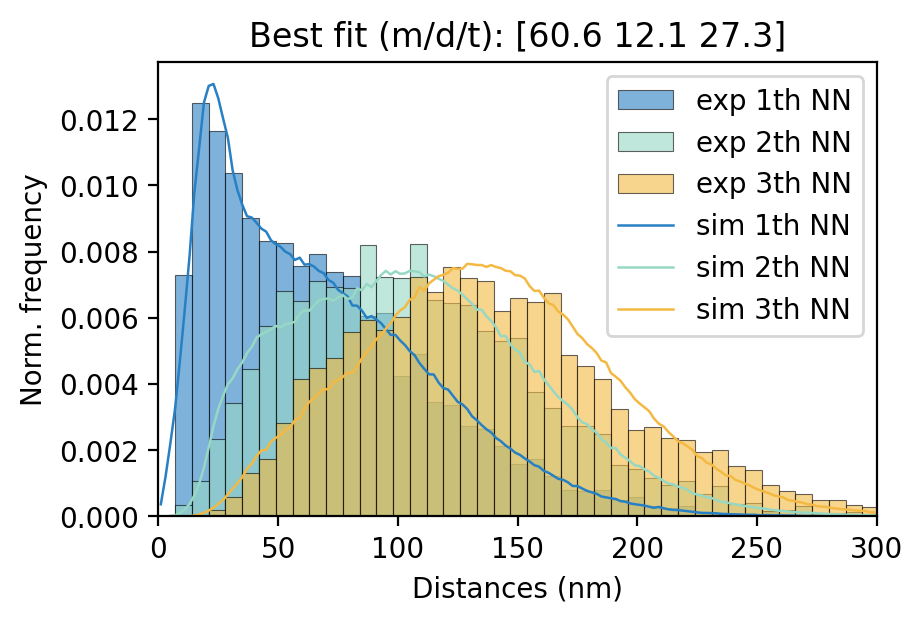

In [12]:
# plot the resulting (nearest neighbor distances) NND histograms - note
# that simulating data for plotting in this case takes a long time since
# we would like to obtain a smooth NND histogram.

# first extract simulated NND
np.random.seed(42)
dists_sim = spinna.get_NN_dist_simulated(
    N_str=best_N_structures,
    N_sim=N_SIM*10,
    mixer=mixer,
)[0]
fig, ax = spinna.plot_NN(
    data1=egfr_coords, data2=egfr_coords, n_neighbors=3, 
    figsize=(4.5, 3),
    mode="hist", binsize=7, xlim=(0, 300), return_fig=True,    
) # experimental data
spinna.plot_NN(
    dist=dists_sim,
    mode="plot", binsize=2, xlim=(0, 300), 
    title=f"Best fit (m/d/t): {mixer.convert_counts_to_props(best_N_structures).round(1)}",
    show_legend=True,
    fig=fig, ax=ax, alpha=1,
)
plt.show()

In [13]:
# lastly, let's look at the fit uncertainty - we use bootstrapping. Note
# that this may take a while to run.
np.random.seed(42)
(props_mean, props_sd), (score, score_sd) = spinner.fit_stoichiometry(
    N_structures=search_space,
    save="", # change to a path to save a .csv file with the scores for each stoichiometry tested
    asynch=True, # multiprocessing
    callback="console", # display progress here
    bootstrap=True,
)
best_N_structures = mixer.convert_props_to_counts(props_mean, n_egfr)

print(f"Mean stoichiometry (m/d/t): {props_mean.round(1)}")
print(f"Uncertainty (std) in stoichiometry (m/d/t): {props_sd.round(1)}")

Bootstrapping 20/20; spinning structures: 100%|██████████| 61/61 [00:18<00:00,  3.33it/s]

Mean stoichiometry (m/d/t): [60.6 12.1 27.3]
Uncertainty (std) in stoichiometry (m/d/t): [3.  6.7 4.2]
